# Simple Autoencoder

In [53]:
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import skimage
import os 

### Load Dataset

In [54]:
shape1 = 64 
shape2 = 64

def import_images(base): 
    images = []
    for i, filename in enumerate(os.listdir(base)): 
        img=skimage.io.imread(base + filename)
        img = skimage.transform.resize(img, (shape1, shape2), mode='reflect')
        images.append(img)
    return np.array(images)

x_train = import_images('Images/train/')
x1_test = import_images('Images/test1/')
x2_test = import_images('Images/test2/')

x_train.shape, x1_test.shape, x2_test.shape

/home/fabrizio/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


((62, 64, 64), (79, 64, 64), (63, 64, 64))

### Create Model

In [55]:
def create_simple_model(k):
    model = Sequential()
    model.add(Dense(256,activation='tanh',input_dim=shape1*shape2))
    model.add(Dense(k,activation='relu', name="latent"))
    model.add(Dense(256,activation='tanh'))
    model.add(Dense(shape1*shape2,activation='sigmoid'))

    model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

    model.fit(x_train.reshape(-1, shape1*shape2),x_train.reshape(-1, shape1*shape2),verbose=0,epochs=100,batch_size=256)
    return model

### Compute performance

In [56]:
# Compute mse

def compute_mses(model, normal, abnormal):
    mses = []
    mse1 = []
    for i in range(len(normal)):
        input1 = normal[i]
        output1 = model.predict(input1.reshape(tuple([1]+ list(model.input_shape[1:]))))[0] # (1, 784) or (1, 28, 28, 1
        mse1.append(mean_squared_error(input1.reshape(shape1*shape2), output1.reshape(shape1*shape2)))
    mse2 = []
    for j in range(len(abnormal)):
        input2 = abnormal[j]
        output2 = model.predict(input2.reshape(tuple([1]+ list(model.input_shape[1:]))))[0] # (1, 784) or (1, 28, 28, 1
        mse2.append(mean_squared_error(input2.reshape(shape1*shape2), output2.reshape(shape1*shape2)))
    mses.append(mse1)
    mses.append(mse2)
    return mses

### Compute ROC

def plot_ROC(mses):
    k = model.get_layer('latent').output_shape[1]
    tpr = []
    fpr = []
    for threshold in np.arange(0,1, 0.001):
        tpr.append(len(np.where(np.array(mses[0])<threshold)[0])/len(mses[0]))
        fpr.append(len(np.where(np.array(mses[1])<threshold)[0])/len(mses[1]))
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, label= 'AUC = %0.2f (k=%d)' % (auc(fpr, tpr), k))
    plt.legend(loc = 4, bbox_to_anchor=(1.50, 0))

### Main

2
4
8
16
32
64
128


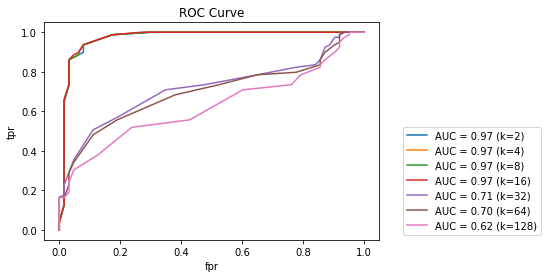

In [57]:
for k in (2, 4, 8, 16, 32, 64, 128):
    print(k)
    model = create_simple_model(k)
    mses = compute_mses(model, x1_test, x2_test)
    plot_ROC(mses)
plt.show()

### Optional Stuff

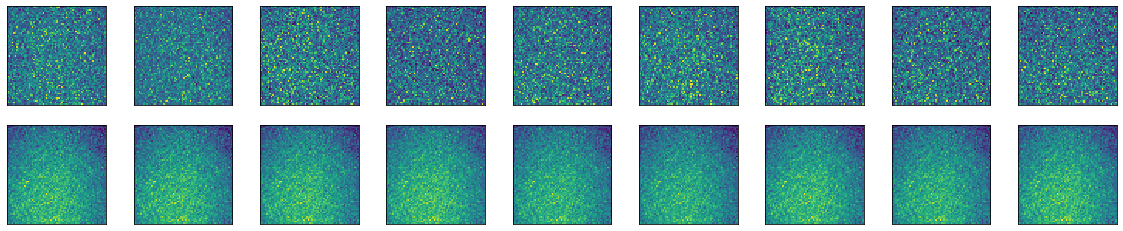

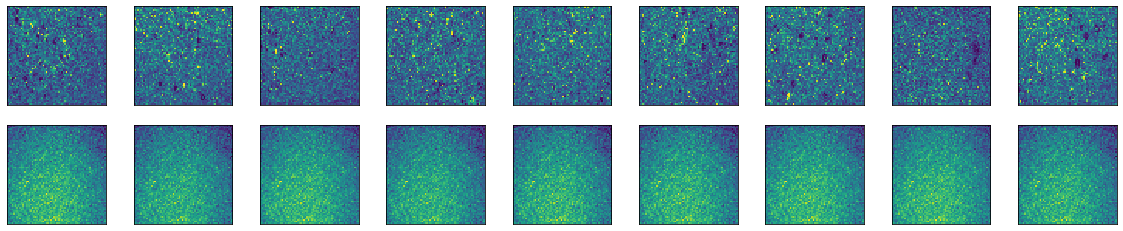

In [59]:
# Plot outputs

def plot_outputs(model, x_test):
    decoded_imgs = model.predict(x_test[0:9].reshape(tuple([9]+ list(model.input_shape[1:]))))
    n = 9
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(shape1, shape2))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i+1 + n)
        plt.imshow(decoded_imgs[i].reshape(shape1, shape2))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_outputs(model, x1_test)
plot_outputs(model, x2_test)

In [61]:
# Widgets

import ipywidgets as widgets
model = create_model(4)

def widget(x1=1, x2=1, x3=1, x4=1):
    get = K.function([model.layers[2].input], [model.layers[3].output])
    input2 = np.array([x1, x2, x3, x4]).reshape(1, 4)
    output = get([input2])
    plt.imshow(output[0].reshape(shape1, shape2))

widgets.interact(widget, 
                 x1=widgets.FloatSlider(min=-1, max=20, step=0.01, value=10), 
                 x2=widgets.FloatSlider(min=-1, max=20, step=0.01, value=20),
                 x3=widgets.FloatSlider(min=-1, max=20, step=0.01, value=10), 
                 x4=widgets.FloatSlider(min=-1, max=20, step=0.01, value=8))

interactive(children=(FloatSlider(value=10.0, description='x1', max=20.0, min=-1.0, step=0.01), FloatSlider(va…

<function __main__.widget(x1=1, x2=1, x3=1, x4=1)>